<a href="https://colab.research.google.com/github/QY428/Machine-Learning-Practice/blob/main/Exercise6_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<bound method NDFrame.head of       1yr  2yr  3yr  5yr  7yr  10yr  20yr  30yr
0      -4   -8   -9   -9   -8    -8    -6    -6
1      -1    0    3    4    5     8     9    11
2       0    2    2    2    0     0    -1    -1
3      -3   -7   -6   -5   -2    -2    -1     1
4      -2   -1   -1    1    1     2     3     4
...   ...  ...  ...  ...  ...   ...   ...   ...
2626    0    0    0    2    1     1     1     2
2627   -1    0    0   -2   -3    -4    -6    -7
2628    0    0    0    1    1     2     1     1
2629    0    0   -1   -2   -3    -5    -7    -7
2630    0    0    1    2    3     3     3     1

[2631 rows x 8 columns]>
PCA: [[ 0.08262571  0.21042337  0.28594527  0.38627686  0.42958101  0.42762798
   0.42641202  0.41071614]
 [-0.24185701 -0.46488362 -0.46677507 -0.31502393 -0.09915402  0.11929196
   0.39409966  0.47842735]
 [-0.68475517 -0.37617188 -0.00619947  0.33186479  0.34941903  0.15269487
  -0.1720554  -0.32314077]
 [-0.68167844  0.57375095  0.18458908 -0.14486959 -0.2648773

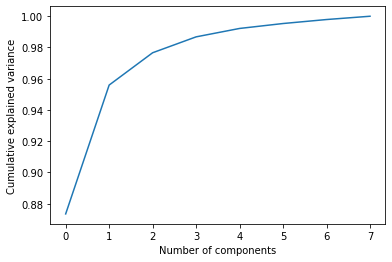

In [ ]:
# Load Package
import numpy as np
from scipy.stats import norm
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Layer, InputSpec,LeakyReLU
from tensorflow.keras.models import Model, load_model
import tensorflow as tf

import sklearn.preprocessing
from numpy.random import seed
seed(100)


import matplotlib.pyplot as plt
from IPython.display import clear_output
#Load Treasury Data and Caculate DoD Change
# Load Data
raw_data = pd.read_csv("TreasuryData.csv")
print(raw_data.head)



# Run PCA. (Results are the same as those from Excel PCA implementation)

pca = PCA(n_components=8)
pca.fit(raw_data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')


X_pca_train = pca.transform(raw_data)
#pd.DataFrame(pca.components_).to_excel("PCA.xlsx")
X_recovered_train = pca.inverse_transform(X_pca_train)
print("PCA:",pca.components_)


In [ ]:
# The mean squared error for PCA is 0.8399
# We now try and improve on PCA using an autoecoder where there are two latent variables
# The are two hidden layers between inputs and latent variables (with 6 and 4 neurons) 
# and two hidden layers (with 4 and 6 neurons) between the latent variable and output
# Activation function is leaky Relu withan alpha parameter of 0.7.

# Set up layers with 6, 4 and 2 neurons for encoder
treas_encoder = keras.models.Sequential([
    Dense(6,input_shape=[len(raw_data.columns)],activation=LeakyReLU(alpha=0.7)),
    Dense(4,input_shape=[6],activation=LeakyReLU(alpha=0.7)),
    Dense(4,input_shape=[4],activation=LeakyReLU(alpha=0.7)),
    Dense(2,input_shape=[4],activation=LeakyReLU(alpha=0.7))])

# Set up layers with 4, 6, and 8 neurons for decoder
treas_decoder = keras.models.Sequential([
    Dense(4,input_shape=[2],activation=LeakyReLU(alpha=0.7)),
    Dense(4,input_shape=[4],activation=LeakyReLU(alpha=0.7)),
    Dense(6,input_shape=[4],activation=LeakyReLU(alpha=0.7)),
    Dense(8,input_shape=[6],activation=LeakyReLU(alpha=0.7))])

# Set up autoencoder 
treas_autoencoder = keras.models.Sequential([treas_encoder,treas_decoder])
treas_autoencoder.compile(loss = "mse", optimizer = "adam")

# Checkpoint function is used here to periodically save a copy of the model. 
# Currently it is set to save the best performing model
checkpoint_cb = keras.callbacks.ModelCheckpoint("treas_autoencoder_leakyrelu_multi_layer_vFinal_v2.h5",save_best_only = True, monitor='loss')

# Early stopping stopsr training early if no improvment is shown after a number of epochs equal to patience 
#  The model then reverts back to the best weights
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='loss',patience = 500,restore_best_weights = True,verbose=1)


# Epochs specifies the maximum number of epochs
treas_history = treas_autoencoder.fit(raw_data,raw_data,epochs = 5000, callbacks=[checkpoint_cb,early_stopping_cb], verbose=0)
treas_autoencoder = keras.models.load_model("treas_autoencoder_leakyrelu_multi_layer_vFinal_v2.h5",custom_objects={'LeakyReLU': LeakyReLU(alpha=0.7)})
mse_test = treas_autoencoder.evaluate(raw_data,raw_data,verbose=0)
print('Neural network mean squared error:', mse_test)


Neural network mean squared error: 0.7978187799453735


# Results
## Original mse by using PCA 
The mean squared error for PCA is **0.8399**

## Keep epochs at 5000
### 1. Leaky Relu with alpha = 0.7

  Restoring model weights from the end of the best epoch: 2744.

  Epoch 3244: early stopping

  Neural network mean squared error: 0.8020686507225037

### 2. Leaky Relu with alpha = 0.1
Neural network mean squared error: 0.8273520469665527

### 3. Leaky Relu with alpha = 0.5
Restoring model weights from the end of the best epoch: 3207.

Epoch 3707: early stopping

Neural network mean squared error: 0.80649334192276

### 4. Encoder adds a layer of Dense. Decoder adds a layer of Dense. (Leaky Relu with alpha = 0.7)

Neural network mean squared error: 0.7978187799453735


```
# Set up layers with 6, 4 and 2 neurons for encoder
treas_encoder = keras.models.Sequential([
    Dense(6,input_shape=[len(raw_data.columns)],activation=LeakyReLU(alpha=0.7)),
    Dense(4,input_shape=[6],activation=LeakyReLU(alpha=0.7)),
    Dense(4,input_shape=[4],activation=LeakyReLU(alpha=0.7)),
    Dense(2,input_shape=[4],activation=LeakyReLU(alpha=0.7))])

# Set up layers with 4, 6, and 8 neurons for decoder
treas_decoder = keras.models.Sequential([
    Dense(4,input_shape=[2],activation=LeakyReLU(alpha=0.7)),
    Dense(4,input_shape=[4],activation=LeakyReLU(alpha=0.7)),
    Dense(6,input_shape=[4],activation=LeakyReLU(alpha=0.7)),
    Dense(8,input_shape=[6],activation=LeakyReLU(alpha=0.7))])
```






# Conclusion

1. The original MSE of PCA is 0.8399.

2. Keeping the Epochs unchanged, the MSE values ​​of the three models that change the LeakyRelu alpha are 0.802, 0.827, and 0.806, respectively. The best of these is the model with an alpha of 0.7.

3. Keep epochs unchanged and alpha to 0.7. But add a layer of Dense to the steps of encoder and decoder respectively. The MSE of the model is 0.798. This is the current best model.

0.8399 > 0.827 > 0.806 > 0.802 > 0.798

By comparing the MSE after changing the parameters several times above, we can see that the results of PCA obtained by autoencoder are generally better than those obtained directly by PCA in sklearn. Therefore, in this question and in the future involving PCA operations, if you want to get better results, you can consider using the autoencoder model for PCA operations, and you can appropriately increase the number of layers of Encoder and Decoder to obtain better results.